# Data preprocessing and visualization

## Imports

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Create filepath list

In [41]:
train_dir = Path('../images/train')
filepaths = list(train_dir.glob(r'**/*.jpeg'))

## Create a dataframe with filepath and picture label

In [42]:
def process_image(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    filepath = pd.Series(filepath, name="Filepath").astype(str)
    labels = pd.Series(labels, name="Label")
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

## Create dataframe

In [43]:
df = process_image(filepaths)

In [44]:
df.head()

,Filepath,Label
0,../images/train/chandler/train11.jpeg,chandler
1,../images/train/rachel/train15.jpeg,rachel
2,../images/train/ross/train19.jpeg,ross
3,../images/train/monica/train18.jpeg,monica
4,../images/train/rachel/train16.jpeg,rachel


## Viualize pictures

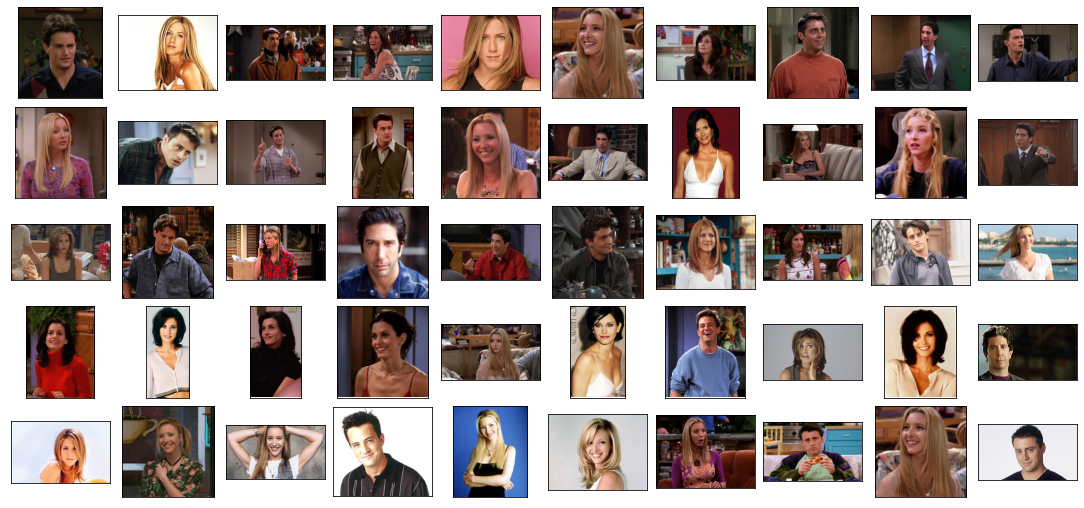

In [45]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    
plt.tight_layout(pad=0.5)
plt.show()
              
                          

# Load the images with a generator

In [46]:
import tensorflow as tf

In [47]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

In [48]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [49]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=45,
    zoom_range=0.25,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.25,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=45,
    zoom_range=0.25,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.25,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 112 validated image filenames belonging to 6 classes.
Found 28 validated image filenames belonging to 6 classes.
Found 35 validated image filenames belonging to 6 classes.


In [50]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# Train the model

In [51]:
different_labels = len(df.Label.unique())

In [52]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(different_labels, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
4/4 [==============================] - 7s 1s/step - loss: 1.9870 - accuracy: 0.1952 - val_loss: 1.7730 - val_accuracy: 0.1429
Epoch 2/10
4/4 [==============================] - 3s 957ms/step - loss: 1.3895 - accuracy: 0.6721 - val_loss: 1.5021 - val_accuracy: 0.3929
Epoch 3/10
4/4 [==============================] - 4s 928ms/step - loss: 1.0514 - accuracy: 0.8172 - val_loss: 1.4452 - val_accuracy: 0.3929
Epoch 4/10
4/4 [==============================] - 4s 1s/step - loss: 0.7162 - accuracy: 0.8846 - val_loss: 1.2021 - val_accuracy: 0.5357
Epoch 5/10
4/4 [==============================] - 4s 920ms/step - loss: 0.4879 - accuracy: 0.9233 - val_loss: 1.1747 - val_accuracy: 0.6071
Epoch 6/10
4/4 [==============================] - 4s 937ms/step - loss: 0.3232 - accuracy: 0.9528 - val_loss: 1.0938 - val_accuracy: 0.7143
Epoch 7/10
4/4 [==============================] - 4s 862ms/step - loss: 0.2002 - accuracy: 0.9943 - val_loss: 1.0193 - val_accuracy: 0.7143
Epoch 8/10
4/4 [==========

# Visualize the result


In [53]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

In [54]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 54.29%


In [55]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

    chandler       0.40      0.50      0.44         4
        joey       0.50      0.40      0.44         5
      monica       0.67      0.80      0.73         5
      phoebe       0.62      0.50      0.56        10
      rachel       0.50      0.57      0.53         7
        ross       0.50      0.50      0.50         4

    accuracy                           0.54        35
   macro avg       0.53      0.55      0.53        35
weighted avg       0.55      0.54      0.54        35



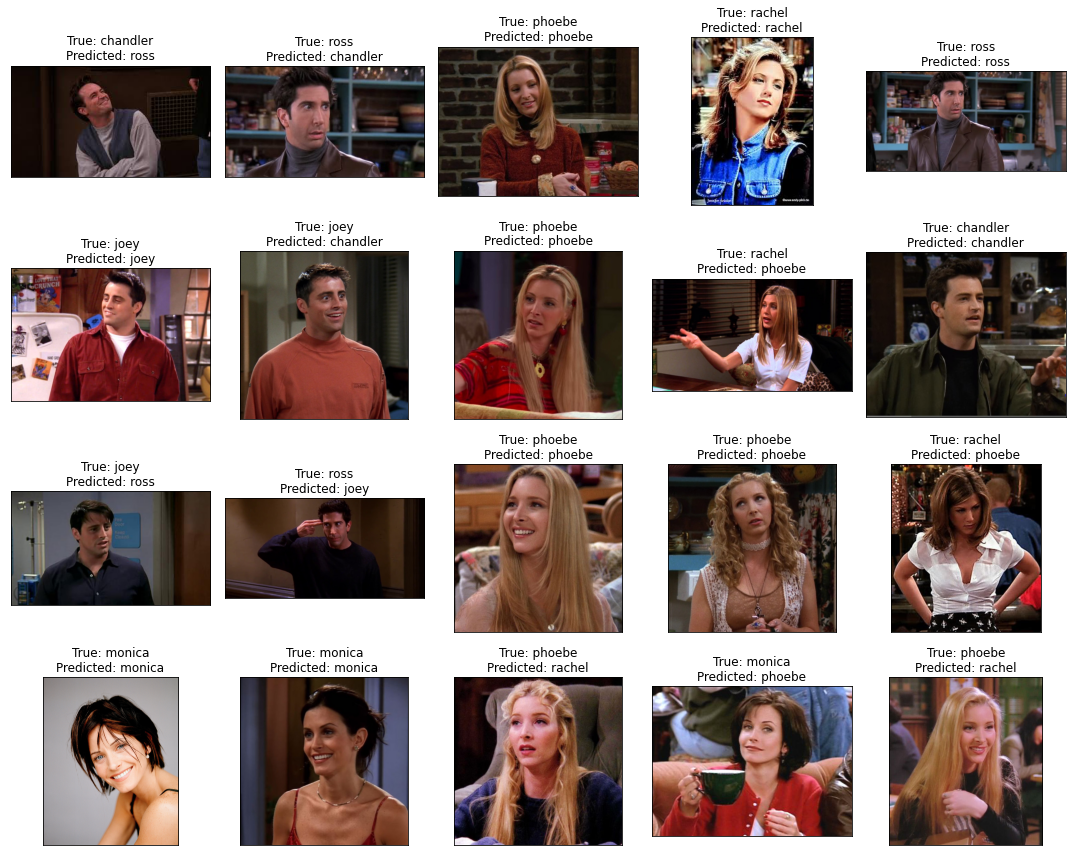

In [56]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()